# Plotting Histogram and Finding white part ratio   

# Setup Configurations

In [33]:
from lightning import seed_everything

cfg = {
    "data":{
        "data_dir": "data",
        "dataset_folder": "RudrakshaDataset"
    },
    "model":{
        "name": "UNet",  # please change the model name as per the model you want to use
        "num_classes": 1,
        "smp_encoder": "resnet18"
    },
    "loss":{
        "name": "GeneralizedDiceLoss"
    },
    "experiment":{
        "name": "Rudraksha Segmentation",
        "num_epochs": 100,
        "patience": 20,
        "image_size": 256,
        "batch_size": 8,
        "learning_rate": 0.001,
        "split_ratio": 0.2,
        "num_workers": 8,
        "accelerator": "cpu", # cpu, cuda, or mps
        "devices": "auto",
        "random_seed": 42
    }
}

seed_everything(cfg["experiment"]["random_seed"])

Global seed set to 42


42

## Initialize WandB and download the model artifact from wandb

In [9]:
import wandb
run = wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhimrazy (rudraksha-segmentation). Use `wandb login --relogin` to force relogin


In [25]:
# This model registry is taken from the artifact of wandb, 
# which was logged while training the model

model_registry = 'rudraksha-segmentation/Semantic Segmentation UNET/model-tqezno7q:v2'
artifact = run.use_artifact(model_registry, type='model')
artifact_dir = artifact.download()


wandb:   1 of 1 files downloaded.  


In [124]:
import os
import torch
# Specify the path to the model checkpoint within the downloaded artifact directory
checkpoint_path = os.path.join(artifact_dir, 'model.ckpt')

# Load the model
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

In [128]:
FOLDER_ROOT_PATH = "/Users/bhimrajyadav/Developer/Personal/rudraksha-segmentation"

In [129]:
import sys
sys.path.append(FOLDER_ROOT_PATH)

In [126]:
from src.model import RudrakshaSegModel
model = RudrakshaSegModel(model_name=cfg["model"]["name"], num_classes=1, smp_encoder="resnet18", loss_fn="GeneralizedDiceLoss")

In [127]:
# load checkpoint weights into model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

## Getting test dataset

In [131]:
from src.dataset import RudrakshaDataModule
from src.io import load_data
from src.utils import split_data
from os.path import join

dataset_path = join(FOLDER_ROOT_PATH,cfg["data"]["data_dir"], cfg["data"]["dataset_folder"])

# load data
images, masks = load_data(dataset_path)

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(
    images,
    masks,
    cfg["experiment"]["split_ratio"],
    cfg["experiment"]["split_ratio"],
    cfg["experiment"]["random_seed"],
)

# data module
data_module = RudrakshaDataModule(
    X_train,
    y_train,
    X_valid,
    y_valid,
    X_test,
    y_test,
    cfg["experiment"]["batch_size"],
    cfg["experiment"]["num_workers"],
    cfg["experiment"]["image_size"],
)


## Inferencing on test dataset

In [132]:
y_true = []
y_pred = []

data_module.setup()
with torch.no_grad():
    model.eval()
    for batch in data_module.test_dataloader():
        x, y = batch
        y_hat = model(x)
        
        y_true.extend(y)
        y_pred.extend(y_hat)

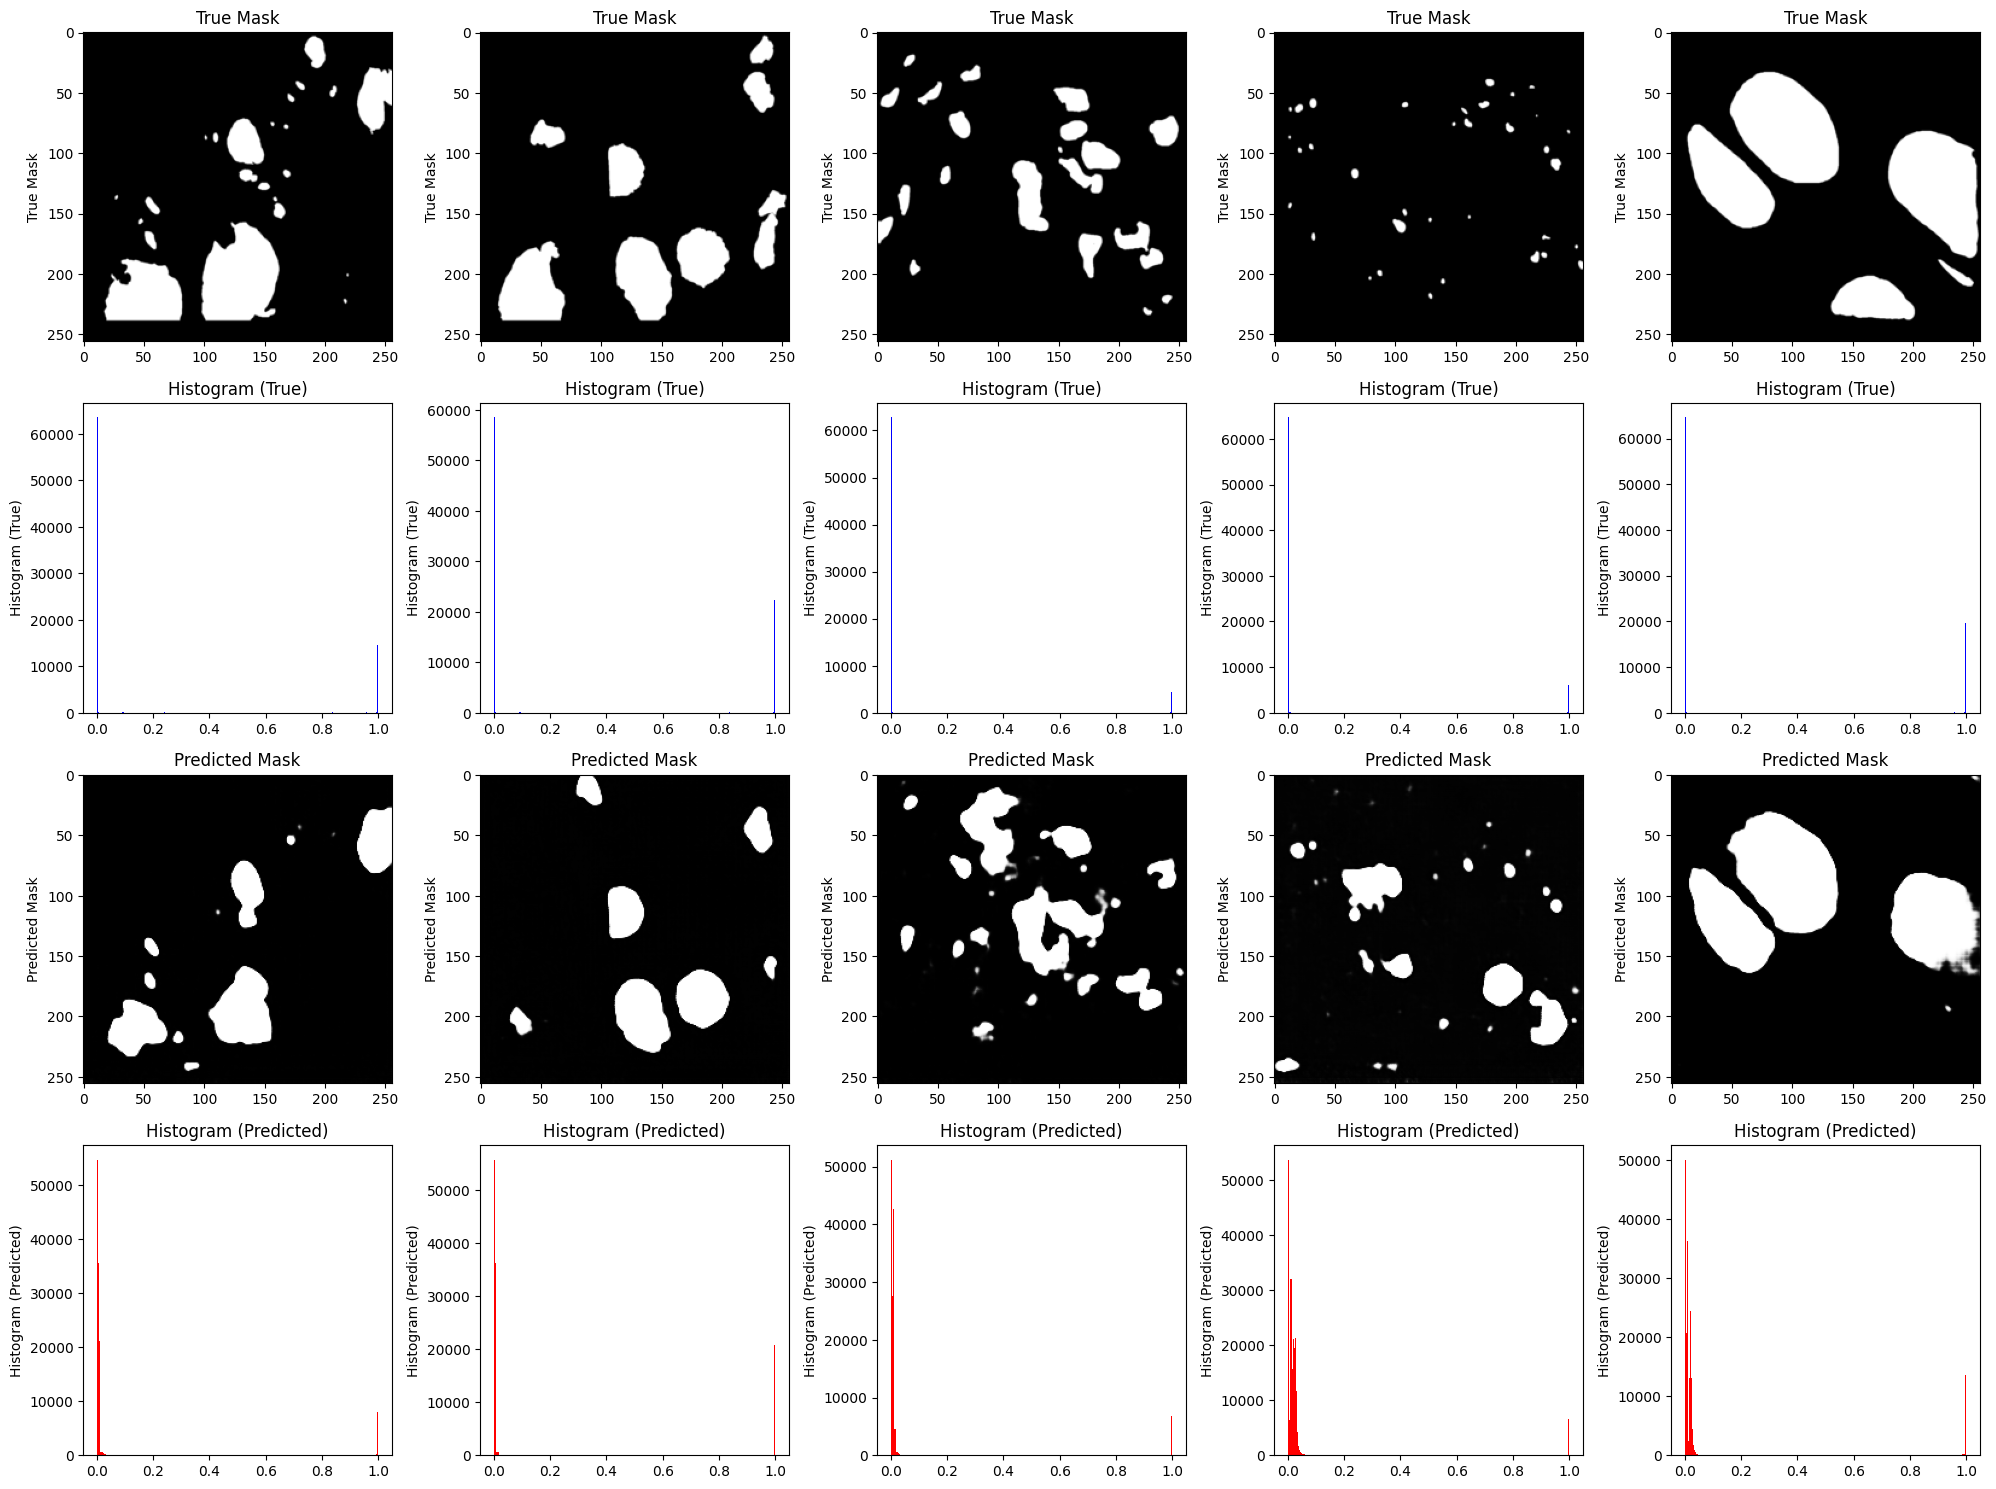

In [161]:
def plot_masks_and_histograms(y_true, y_pred):
    # Calculate the number of rows needed (5 images per row)
    num_rows = 4

    # Create subplots with 4 rows and 5 columns initially
    fig, axs = plt.subplots(4, 5, figsize=(20, 15))

    for i in range(num_rows):
        for j in range(5):
            idx = i * 5 + j  # Calculate the index of the image in the arrays
            if idx >= len(y_true):
                break  # Break if we have displayed all images
            # Plot the first row of the true mask
            axs[0, j].imshow(y_true[idx].permute(1,2,0), cmap='gray')
            axs[0, j].set_title('True Mask')

            # Plot the histogram of the true mask
            axs[1, j].hist(y_true[idx].flatten(), bins=256, color='blue')
            axs[1, j].set_title('Histogram (True)')

            # Plot the predicted mask
            axs[2, j].imshow(y_pred[idx].sigmoid().permute(1,2,0), cmap='gray')
            axs[2, j].set_title('Predicted Mask')

            # Plot the histogram of the predicted mask
            axs[3, j].hist(y_pred[idx].sigmoid().flatten(), bins=256, color='red')
            axs[3, j].set_title('Histogram (Predicted)')

    # Set common y-axis labels
    for j in range(5):
        axs[0, j].set_ylabel('True Mask')
        axs[1, j].set_ylabel('Histogram (True)')
        axs[2, j].set_ylabel('Predicted Mask')
        axs[3, j].set_ylabel('Histogram (Predicted)')

    plt.tight_layout()
    plt.show()

plot_masks_and_histograms(y_true, y_pred)

In [160]:
# white pixels ratio

for (mask, pred_mask) in zip(y_true, y_pred):  

    no_of_white_pixel_in_mask = torch.sum(mask.flatten())
    no_of_white_pixel_in_pred_mask = torch.sum(pred_mask.sigmoid().flatten())

    print(f"White pixels in mask: {no_of_white_pixel_in_mask}")
    print(f"White pixels in predicted mask: {no_of_white_pixel_in_pred_mask}")
    print(f"White pixels ratio: {no_of_white_pixel_in_pred_mask/no_of_white_pixel_in_mask}")
    print()

White pixels in mask: 4969.1220703125
White pixels in predicted mask: 5305.4482421875
White pixels ratio: 1.067683219909668

White pixels in mask: 9090.1376953125
White pixels in predicted mask: 8356.572265625
White pixels ratio: 0.9193009734153748

White pixels in mask: 3898.093994140625
White pixels in predicted mask: 4998.0703125
White pixels ratio: 1.2821831703186035

White pixels in mask: 588.184326171875
White pixels in predicted mask: 4467.3076171875
White pixels ratio: 7.595080852508545

White pixels in mask: 20709.62890625
White pixels in predicted mask: 16043.3037109375
White pixels ratio: 0.7746784687042236

White pixels in mask: 1652.058837890625
White pixels in predicted mask: 9833.451171875
White pixels ratio: 5.952240467071533

White pixels in mask: 6181.498046875
White pixels in predicted mask: 6020.1669921875
White pixels ratio: 0.9739009737968445

White pixels in mask: 2478.439208984375
White pixels in predicted mask: 7241.14794921875
White pixels ratio: 2.92165637016